### Data Sources

Spark has six “core” data sources and hundreds of external data sources written by the community. Following are Spark’s core data
sources:

* CSV
* JSON
* Parquet
* ORC
* JDBC/ODBC connections
* Plain-text files

As mentioned, Spark has numerous community-created data sources. Here’s just a small sample:

* Cassandra
* HBase
* MongoDB
* AWS Redshift
* XML
* And many, many others

### Basics of Reading Data

The foundation for reading data in Spark is the DataFrameReader. We access this through the SparkSession via the read attribute:

__spark.read__

After we have a DataFrame reader, we specify several values:

* The format
* The schema
* The read mode
* A series of options

Here’s an example of the overall layout:

spark.read.format("csv")
.option("mode", "FAILFAST")
.option("inferSchema", "true")
.option("path", "path/to/file(s)")
.schema(someSchema)
.load()


### Read Mode

Reading data from an external source naturally entails encountering malformed data, especially
when working with only semi-structured data sources. Read modes specify what will happen
when Spark does come across malformed records. 

| Read mode | Description |
| --------- | ----------- |
| permissive | Sets all fields to null when it encounters a corrupted record and places all corrupted records in a string column called _corrupt_record |
| dropMalformed |Drops the row that contains malformed records |
| failFast | Fails immediately upon encountering malformed records |


The default mode is permissive



### Write API Structure

The core structure for writing data is as follows:



<span style="color:green">DataFrameWriter.format(...).option(...).partitionBy(...).bucketBy(...).sortBy(..).save()t</span>.

We will use this format to write to all of our data sources. format is optional because by default,
Spark will use the arquet format. option, again, allows us to configure how to write out our
given data. PartitionBy, bucketBy, and sortBy work only for file-based data sources; you can
use them to control the specific layout of files at the destination.

### Basics of Writing the Data

The foundation for writing data is quite similar to that of reading data. Instead of the
DataFrameReader, we have the DataFrameWriter. Because we always need to write out some
given data source, we access the DataFrameWriter on a per-DataFrame basis via the write
attribute:

<span style="color:green"> dataFrame.write </span>

After we have a DataFrameWriter, we specify three values: the format, a series of options,
and the save mode

<span style="color:green">dataframe.write.format("csv").option("mode", "OVERWRITE").option("dateFormat", "yyyy-MM-dd").option("path", "path/to/file(s)").save()</span>

### Saves mode

Save modes specify what will happen if Spark finds data at the specified location (assuming all else equal).

| Save mode | Description |
| ---------  | ---------- |
| append | Appends the output files to the list of files that already exist at that location |
| overwrite | Will completely overwrite any data that already exists there |
| errorIfExists | Throws an error and fails the write if data or files already exist at the specified location |
| ignore | If data or files exist at the location, do nothing with the current DataFrame |

The default is errorIfExists. This means that if Spark finds data at the location to which
you’re writing, it will fail the write immediately.
We’ve largely covered the core concepts that you’re going to need when using data sources, so
now let’s dive into each of Spark’s native data sources.

### CSV Files

CSV stands for commma-separated values. This is a common text file format in which each line
represents a single record, and commas separate each field within a record. CSV files, while
seeming well structured, are actually one of the trickiest file formats you will encounter because
not many assumptions can be made in production scenarios about what they contain or how they
are structured. For this reason, the CSV reader has a large number of options. These options give
you the ability to work around issues like certain characters needing to be escaped—for example,
commas inside of columns when the file is also comma-delimited or null values labeled in an
unconventional way

### CSV Options

| Read/Write | key | Potential values | Default | Description |
| ---------- | ------ |---------------- | -------- | ---------- |
| Both | sep | Any single string character | , | The single character that is used as separator for each field and value. |
| Both | header | true, false | false | A Boolean flag that declares whether the first line in the file(s) are the names of the columns. |
| Read | escape | Any string character | \   | The character Spark should use to escape other characters in the file. |
| Read | inferSchema | true, False | false  |  Specifies whether Spark should infer column types when reading the file.|
| Read | ignoreLeadingWhiteSpace | true, false | false  | Declares whether leading spaces from values being read should be skipped. |
| Read | ignoreTrailingWhiteSpace | true, false | false | Declares whether trailing spaces from values being read should be skipped. |
| Both | nullValue | AnyString character | "" | Declares what character represents a null value in the fill. |
| Both | nanValue | Any string character | NaN | Declares what character represents a NaN or missing character in the CSV file. |
| Both | positiveInf |  Any string or character | Inf | Declares what character(s) represent a positive infinite value.  |

### Reading CSV Files


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.Builder().appName("chapter-08-data-sources").getOrCreate()

23/11/28 07:30:30 WARN Utils: Your hostname, FM-PC-LT-342 resolves to a loopback address: 127.0.1.1; using 192.168.1.75 instead (on interface wlp0s20f3)
23/11/28 07:30:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/28 07:30:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.types import StructType, StructField, StringType, LongType

myManualSchema = StructType([
    StructField("DEST_COUNTRY_NAME", StringType(), True),
    StructField("ORIGIN_COUNTRY_NAME", StringType(), True),
    StructField("count", LongType(), False)
])

spark.read.format("csv") \
    .option("header", "true") \
    .option("mode", "FAILFAST") \
    .schema(myManualSchema) \
    .load("datasets/datas/flight-data/csv/2010-summary.csv") \
    .show(5)


+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|    1|
|    United States|            Ireland|  264|
|    United States|              India|   69|
|            Egypt|      United States|   24|
|Equatorial Guinea|      United States|    1|
+-----------------+-------------------+-----+
only showing top 5 rows



### Writing CSV files

Just as with reading data, there are a variety of options for writing data when
we write CSV files. This is a subset of the reading options because many do not apply when
writing data (like maxColumns and inferSchema). Here’s an example:

In [3]:
csvFile = spark.read.format("csv")\
.option("header", "true")\
.option("mode", "FAILFAST")\
.option("inferSchema", "true")\
.load("datasets/datas/flight-data/csv/2010-summary.csv")

csvFile.write.format("csv").mode("overwrite").option("sep", "\t")\
.save("/tmp/my-tsv-file.tsv")

When you list the destination directory, you can see that my-tsv-file is actually a folder with
numerous files within it:

<span style = "color:green"> $ ls /tmp/my-tsv-file.tsv/ </span>

<span style = "color:green"> /tmp/my-tsv-file.tsv/part-00000-35cf9453-1943-4a8c-9c82-9f6ea9742b29.csv </span>

This actually reflects the number of partitions in our DataFrame at the time we write it out. If we
were to repartition our data before then, we would end up with a different number of files

### JSON Files

In Spark, when we refer to JSON files, we refer to
line-delimited JSON files. This contrasts with files that have a large JSON object or array per
file. The line-delimited versus multiline trade-off is controlled by a single option: multiLine. When
you set this option to true, you can read an entire file as one json object and Spark will go
through the work of parsing that into a DataFrame. Line-delimited JSON is actually a much more
stable format because it allows you to append to a file with a new record (rather than having to
read in an entire file and then write it out), which is what we recommend that you use. Another
key reason for the popularity of line-delimited JSON is because JSON objects have structure,
and JavaScript (on which JSON is based) has at least basic types. This makes it easier to work
with because Spark can make more assumptions on our behalf about the data.

### JSON Options

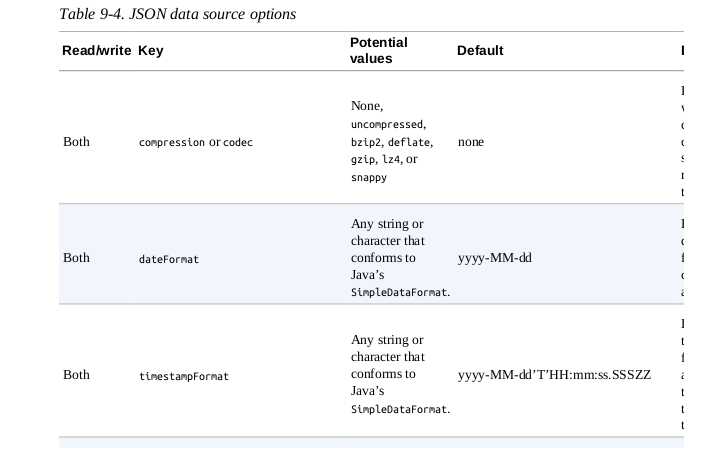

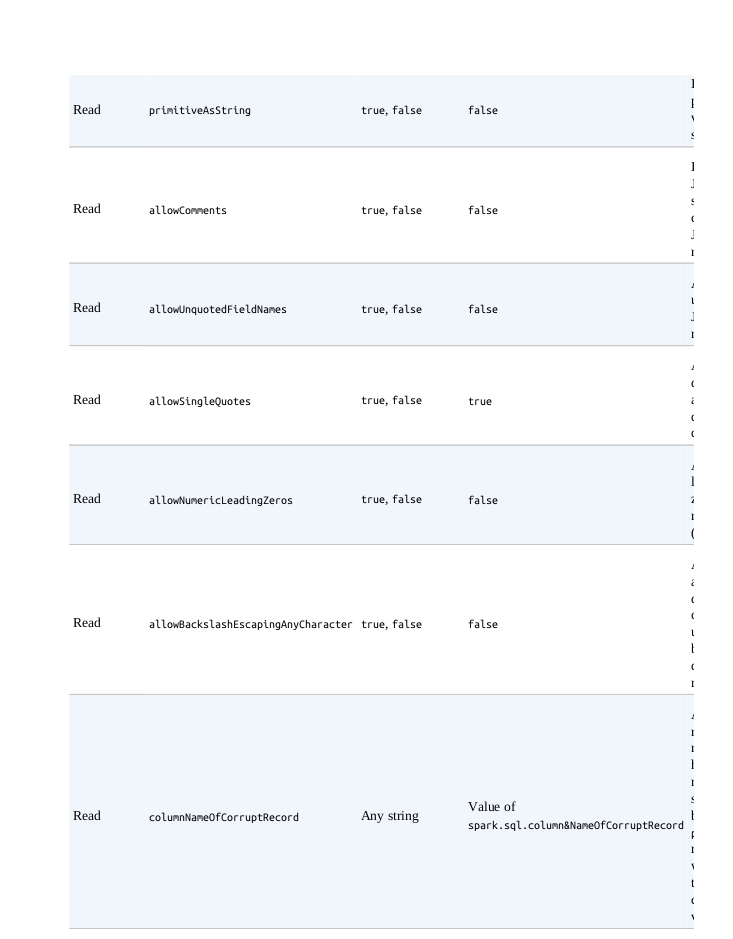

### Reading JSON Files

In [4]:
spark.read.format("json").option("mode", "FAILFAST")\
.option("inferSchema", "true")\
.load("datasets/datas/flight-data/json/2010-summary.json").show(5)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|    1|
|    United States|            Ireland|  264|
|    United States|              India|   69|
|            Egypt|      United States|   24|
|Equatorial Guinea|      United States|    1|
+-----------------+-------------------+-----+
only showing top 5 rows



### Writing JSON Files

Writing JSON files is just as simple as reading them, and, as you might expect, the data source
does not matter. Therefore, we can reuse the CSV DataFrame that we created earlier to be the
source for our JSON file. This, too, follows the rules that we specified before: one file per
partition will be written out, and the entire DataFrame will be written out as a folder. It will also
have one JSON object per line:

In [ ]:
# in Python
csvFile.write.format("json").mode("overwrite").save("/tmp/my-json-file.json")

### Parquet Files

Parquet is an open source column-oriented data store that provides a variety of storage optimizations, especially for analytics workloads. It provides columnar compression, which saves storage space and allows for reading individual columns instead of entire files. It is a file
format that works exceptionally well with Apache Spark and is in fact the default file format. We
recommend writing data out to Parquet for long-term storage because reading from a Parquet file
will always be more efficient than JSON or CSV. Another advantage of Parquet is that it
supports complex types. This means that if your column is an array (which would fail with a
CSV file, for example), map, or struct, you’ll still be able to read and write that file without
issue.

### Reading Parquet Files

Parquet has very few options because it enforces its own schema when storing data. Thus, all you need to set is the format and you are good to go. We can set the schema if we have strict requirements for what our DataFrame should look like. Oftentimes this is not necessary because we can use schema on read, which is similar to the inferSchema with CSV files. However, with Parquet files, this method is more powerful because the schema is built into the file itself (so no
inference needed).

In [ ]:
# in Python
spark.read.format("parquet")\
.load("/data/flight-data/parquet/2010-summary.parquet").show(5)

### Parquet options

As we just mentioned, there are very few Parquet options—precisely two, in fact—because it has
a well-defined specification that aligns closely with the concepts in Spark

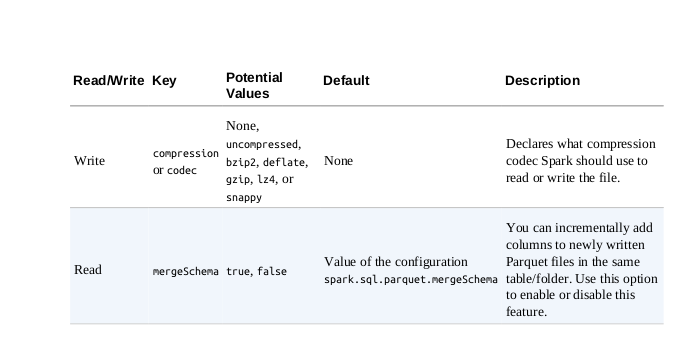

### Writing Parquet Files



In [ ]:
csvFile.write.format("parquet").mode("overwrite")\
.save("/tmp/my-parquet-file.parquet")

### ORC Files 

ORC (Optimized Row Columnar) is a file format used for storing large-scale datasets in a column-oriented way. ORC files are highly optimized for analytical queries, offering a significant improvement in performance compared to row-based storage formats like CSV or JSON.

In PySpark, ORC files are supported out of the box, allowing users to easily read and write data in this format. PySpark provides an API for working with ORC files, including the ability to read ORC files into a DataFrame using the spark.read.orc() method, and write DataFrames to ORC files using the DataFrame.write.orc() method.

ORC files can be compressed, which makes them an ideal choice for storing large amounts of data. They can be used for a variety of use cases, including data warehousing, ETL (Extract, Transform, Load) processes, and machine learning applications.

### Reading Orc Files

In [ ]:
spark.read.format("orc").load("/data/flight-data/orc/2010-summary.orc").show(5)

### Writing ORC Files


In [ ]:
csvFile.write.format("orc").mode("overwrite").save("/tmp/my-json-file.orc")

### Advance I/O Concepts

we can control the parallelism of files that we write by controlling the
partitions prior to writing. We can also control specific data layout by controlling two things:
bucketing and partitioning (discussed momentarily).


### Splittable File Types and Compression

Certain file formats are fundamentally “splittable.” This can improve speed because it makes it
possible for Spark to avoid reading an entire file, and access only the parts of the file necessary
to satisfy your query. Additionally if you’re using something like Hadoop Distributed File
System (HDFS), splitting a file can provide further optimization if that file spans multiple
blocks. In conjunction with this is a need to manage compression. Not all compression schemes
are splittable. How you store your data is of immense consequence when it comes to making
your Spark jobs run smoothly. We recommend Parquet with gzip compression.


### Reading Data in Parallel

Multiple executors cannot read from the same file at the same time necessarily, but they can readdifferent files at the same time. In general, this means that when you read from a folder with multiple files in it, each one of those files will become a partition in your DataFrame and be read in by available executors in parallel (with the remaining queueing up behind the others)

### Writing Data in Parallel

The number of files or data written is dependent on the number of partitions the DataFrame has at the time you write out the data. **By default, one file is written per partition of the data**. This means that although we specify a “file,” it’s actually a number of files within a folder, with the name of the specified file, with one file per each partition that is written.

**For example,** the following code

<span style = "color:green">csvFile.repartition(5).write.format("csv").save("/tmp/multiple.csv")</span>

will end up with five files inside of that folder. As you can see from the list call:

<span style = "color:green">ls /tmp/multiple.csv

<span style = "color:green">/tmp/multiple.csv/part-00000-767df509-ec97-4740-8e15-4e173d365a8b.csv

<span style = "color:green">/tmp/multiple.csv/part-00001-767df509-ec97-4740-8e15-4e173d365a8b.csv

<span style = "color:green">/tmp/multiple.csv/part-00002-767df509-ec97-4740-8e15-4e173d365a8b.csv

<span style = "color:green">/tmp/multiple.csv/part-00003-767df509-ec97-4740-8e15-4e173d365a8b.csv

<span style = "color:green">/tmp/multiple.csv/part-00004-767df509-ec97-4740-8e15-4e173d365a8b.csv

### Partitioning

Partitioning is a tool that allows you to control what data is stored (and where) as you write it. When you write a file to a partitioned directory (or table), you basically encode a column as a folder. What this allows you to do is skip lots of data when you go to read it in later, allowing you to read in only the data relevant to your problem instead of having to scan the complete dataset. These are supported for all file-based data sources:

In [5]:
csvFile.limit(10).write.mode("overwrite").partitionBy("DEST_COUNTRY_NAME")\
.save("/tmp/partitioned-files.parquet")

Upon writing, you get a list of folders in your Parquet “file”:

Each of these will contain Parquet files that contain that data where the previous predicate was
true:

<span style = "color:green">$ ls /tmp/partitioned-files.parquet/DEST_COUNTRY_NAME=Senegal/</span>

<span style = "color:green">part-00000-tid.....parquet</span>

This is probably the lowest-hanging optimization that you can use when you have a table that
readers frequently filter by before manipulating. For instance, date is particularly common for a
partition because, downstream, often we want to look at only the previous week’s data (instead
of scanning the entire list of records). This can provide massive speedups for readers.

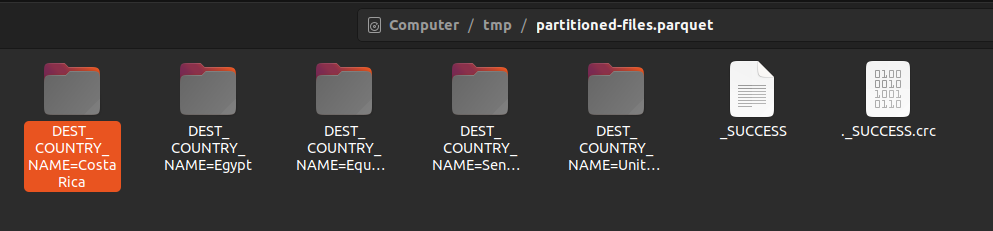